In [1]:
# !pip install adapter-transformers
# !pip install datasets
# !pip install evaluate

1. mbert-en
2. mbert-es

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os, sys
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



import json
from transformers import AutoTokenizer, AdapterConfig, AutoAdapterModel, AutoConfig
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction, TrainerCallback
from transformers import AutoModelForSequenceClassification, Trainer
from transformers import EarlyStoppingCallback, IntervalStrategy, DataCollatorForLanguageModeling
from datasets import Dataset, DatasetDict

from tqdm import tqdm

import numpy as np
from datasets import concatenate_datasets, load_metric
import evaluate
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import random
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


In [3]:
df_en = pd.read_csv("../data/subtask_2/en/train.tsv", sep='\t')
df_en=df_en.drop(df_en.columns[0], axis=1)

df_es = pd.read_csv("../data/subtask_2/es/train.tsv", sep='\t')
df_es=df_es.drop(df_es.columns[0], axis=1)

In [4]:
mapping = {
    "A": 0,
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5
}
df_en["label"] = df_en['label'].map(mapping)
df_es["label"] = df_es['label'].map(mapping)

In [5]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, concatenate_datasets

# Split your data into train and test sets
dataset_train_en, dataset_test_en = train_test_split(df_en, test_size=0.1, random_state=42)
dataset_train_es, dataset_test_es = train_test_split(df_es, test_size=0.1, random_state=42)

# Further split your train data into train and validation sets
dataset_train_en, dataset_valid_en = train_test_split(dataset_train_en, test_size=0.1, random_state=42)
dataset_train_es, dataset_valid_es = train_test_split(dataset_train_es, test_size=0.1, random_state=42)


# Concatenate the datasets
dataset_train_compl = pd.concat([dataset_train_en, dataset_train_es])
dataset_valid_compl = pd.concat([dataset_valid_en, dataset_valid_es])
dataset_test_compl = pd.concat([dataset_test_en, dataset_test_es])

print(len(dataset_train_compl))
print(len(dataset_valid_compl))
print(len(dataset_test_compl))

35922
3993
4436


In [6]:
# language_model = "xlm-roberta-base"
language_model = "bert-base-multilingual-cased"
# language_model = "microsoft/deberta-v3-base"
# language_model = "prajjwal1/bert-tiny"
# language_model = "distilbert-base-cased"
# language_model = "roberta-base-openai-detector"
# language_model = "Hello-SimpleAI/chatgpt-detector-roberta"


tokenizer = AutoTokenizer.from_pretrained(language_model)

dataset_train = Dataset.from_pandas(dataset_train_compl)
dataset_valid = Dataset.from_pandas(dataset_valid_compl)
dataset_test = Dataset.from_pandas(dataset_test_compl)

def encode_batch(batch):
    """Encodes a batch of input data using the model tokenizer."""
    return tokenizer(batch["text"], max_length=80, truncation=True, padding="max_length")


dataset_train = dataset_train.rename_column("label", "labels")
dataset_train = dataset_train.map(encode_batch, batched=True)
dataset_train.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

dataset_valid = dataset_valid.rename_column("label", "labels")
dataset_valid = dataset_valid.map(encode_batch, batched=True)
dataset_valid.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

dataset_test = dataset_test.map(encode_batch, batched=True)
dataset_test = dataset_test.rename_column("label", "labels")
dataset_test.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

In [7]:
dataset_train.to_pandas().head()

,text,labels,__index_level_0__,input_ids,token_type_ids,attention_mask
0,"For example, you can use verbal cues like sit,...",5,3211,"[101, 11399, 14351, 117, 13028, 10944, 11760, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,The statement made by Jane Collins MP is compl...,5,14617,"[101, 10117, 33311, 11019, 10155, 15549, 16949...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,The government defended the arrest of the two ...,4,2316,"[101, 10117, 12047, 63798, 10105, 45165, 10108...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"When it comes to trimming your beard, you’ll n...",4,14340,"[101, 12242, 10271, 21405, 10114, 102859, 1640...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,the lyrics are good and the vocals of amanda s...,2,20228,"[101, 10105, 28030, 10301, 15198, 10111, 10105...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Modelling

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(language_model, num_labels=len(dataset_train_compl.label.unique()), ignore_mismatched_sizes=True)
  
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
early_stop = EarlyStoppingCallback(3)

training_args = TrainingArguments(
    learning_rate=1e-6,
    num_train_epochs=10,
    seed = 42,
    output_dir="./training_output_multilingual2",
    # label_names=["generated", "human"]
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    dataloader_num_workers=32,
    logging_steps=100,
    save_total_limit = 2,
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='tensorboard',
    metric_for_best_model='f1'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_valid,
    compute_metrics=compute_metrics,
    callbacks = [early_stop]
)

trainer.train()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.740400,1.694445,0.263461,0.232807,0.266380,0.260889
2,1.468000,1.426990,0.381668,0.366121,0.363508,0.382875
3,1.308900,1.278915,0.429001,0.408448,0.417358,0.430093
4,1.220000,1.205247,0.460806,0.441059,0.444196,0.459994
5,1.183700,1.185913,0.465314,0.440553,0.448156,0.463216
6,1.149600,1.174869,0.474831,0.453787,0.466293,0.472133
7,1.137900,1.138115,0.483346,0.461733,0.466807,0.481072
8,1.097000,1.140300,0.483847,0.466462,0.472536,0.481583
9,1.111400,1.141646,0.481843,0.462666,0.470696,0.479386
10,1.101800,1.135179,0.485349,0.464817,0.471625,0.482920


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 3993
  Batch size = 64
Saving model checkpoint to ./training_output_multilingual2/checkpoint-562
Configuration saved in ./training_output_multilingual2/checkpoint-562/config.json
Model weights saved in ./training_output_multilingual2/checkpoint-562/pytorch_model.bin
Deleting older checkpoint [training_output_multilingual2/checkpoint-36] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this m

TrainOutput(global_step=5620, training_loss=1.2745336244114778, metrics={'train_runtime': 1592.688, 'train_samples_per_second': 225.543, 'train_steps_per_second': 3.529, 'total_flos': 1.47684605852736e+16, 'train_loss': 1.2745336244114778, 'epoch': 10.0})

In [9]:
dataset_test_en = Dataset.from_pandas(dataset_test_en)
dataset_test_es = Dataset.from_pandas(dataset_test_es)


dataset_test_en = dataset_test_en.map(encode_batch, batched=True)
dataset_test_en = dataset_test_en.rename_column("label", "labels")
dataset_test_en.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])


dataset_test_es = dataset_test_es.map(encode_batch, batched=True)
dataset_test_es = dataset_test_es.rename_column("label", "labels")
dataset_test_es.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])


t_metrics_en = trainer.evaluate(dataset_test_en)
t_metrics_es = trainer.evaluate(dataset_test_es)


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2242
  Batch size = 64


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2194
  Batch size = 64


In [28]:
list_rows = []

device = "cuda:0"

for row in tqdm(dataset_test, desc="Evaluating"):
    model.eval()
    input_ids = torch.tensor(row['input_ids']).unsqueeze(0).to(device)  # Move to the desired device
    attention_mask = torch.tensor(row['attention_mask']).unsqueeze(0).to(device)  # Move to the desired device
    encoding = {'input_ids': input_ids, 'attention_mask': attention_mask}  # Create input dictionary

    with torch.no_grad():
        output = model(**encoding)  # Pass the input dictionary using ** operator

    pred_intent = output.logits.argmax(-1).cpu().numpy()[0]

    row['pred_intent'] = pred_intent
    row['intent'] = row['labels'].cpu().numpy().astype(int)

    list_rows.append(row)


Evaluating:   0%|          | 0/4436 [00:00<?, ?it/s]/tmp/ipykernel_584541/201674580.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(row['input_ids']).unsqueeze(0).to(device)  # Move to the desired device
/tmp/ipykernel_584541/201674580.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(row['attention_mask']).unsqueeze(0).to(device)  # Move to the desired device
Evaluating: 100%|██████████| 4436/4436 [01:13<00:00, 60.54it/s]


In [38]:
import pandas as pd

df


,predicted_class,class
0,0,0
1,1,2
2,5,5
3,5,5
4,4,3
...,...,...
4431,0,0
4432,0,0
4433,3,4
4434,5,5


In [68]:
import pandas as pd

# Assuming `list_rows` contains the list of dictionaries



# Convert NumPy arrays to integers
# df['predicted_class'] = df['predicted_class'].apply(lambda x: x.item())
# df['class'] = df['class'].apply(lambda x: x.item())

# # Map integer values to labels

df


,predicted_class,class
0,A,A
1,B,C
2,F,F
3,F,F
4,E,D
...,...,...
4431,A,A
4432,A,A
4433,D,E
4434,F,F


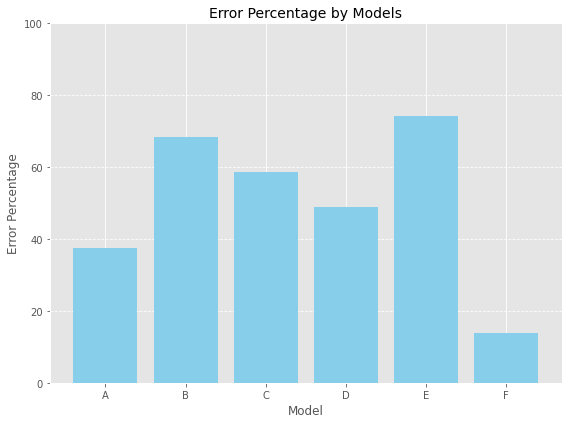

<Figure size 432x288 with 0 Axes>

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

mapping = {
    0: "A",
    1: "B",
    2: "C",
    3: "D",
    4: "E",
    5: "F"
}

df = pd.DataFrame(list_rows)[['pred_intent', 'intent']]
df.columns = ["predicted_class", "class"]

# Convert class column to a Series
df['class'] = df['class'].apply(lambda x: x.item())


df['predicted_class'] = df['predicted_class'].map(mapping)
df['class'] = df['class'].map(mapping)

# Count the number of errors by comparing predicted_class and class
error_counts = df[df['predicted_class'] != df['class']].groupby('class').size()

# Count the total number of instances for each class
total_counts = df['class'].value_counts()

# Calculate the error percentage for each class
error_percentage = (error_counts / total_counts) * 100

# Create a bar chart of error percentages
plt.figure(figsize=(8, 6))  # Adjust the figure size as desired
plt.bar(error_percentage.index, error_percentage.values, color='skyblue')

# Add labels and title
plt.xlabel('Model', fontsize=12)
plt.ylabel('Error Percentage', fontsize=12)
plt.title('Error Percentage by Models', fontsize=14)

# Customize the axes ticks and grid lines
# plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 100)

# plt.style.use('ggplot')
plt.savefig('model_error_rate.png', dpi=200,bbox_inches='tight')

plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--')

# Display the bar chart
plt.tight_layout()  # Improve spacing between elements
plt.show()
plt.clf()

In [81]:
df.to_csv("model_error_rate.csv")

In [ ]:
pd.DataFrame([t_metrics_en])

In [ ]:
pd.DataFrame([t_metrics_es])